### Сайт https://www.kaggle.com/uciml/sms-spam-collection-dataset

In [74]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

import os
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

import dataframe_image as dfi

# Spam

In [75]:
df = pd.read_csv("spam.csv", sep=",", usecols=[0, 1], encoding='latin-1')

In [107]:
df.head()
dfi.export(df.head(),"sms-spam.png")

In [77]:
# Количество пропусков в столбцах (все хорошо)
NAs = pd.concat([df.isnull().sum()], axis=1)
NAs

,0
v1,0
v2,0


In [78]:
# Сбалансированность (все вполне хорошо)
df['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

CountVectorizer() - построение для каждого комментария вектора количеств каждого слова из словаря всех слов;
TfidfVectorizer() - использование меры TF-IDF: TF-IDF(термина а) = TF(термина а) * IDF(термина а), IDF(термина а) = Log(Общее количество документов / Количество документов, в которых встречается термин а) - важность термина a, TF(термина а) = (Количество раз, когда термин а встретился в тексте / количество всех слов в тексте)

In [79]:
y = pd.get_dummies(df['v1'])['spam']

In [80]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('punkt')

class LemmaTokenizer(object):
    def __call__(self, text):
        return [lemmatizer.lemmatize(t) for t in word_tokenize(text)]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Владислав\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Владислав\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [81]:
my_stop_words = [lemmatizer.lemmatize(t) for t in stopwords.words('english')]

In [82]:
vectorizers = ['CountVectorizer', 'TfidfVectorizer']
methods = ['GaussianNB', 'MultinomialNB', 'ComplementNB', 'BernoulliNB', 'LogisticRegression']
# alpha - параметр сглаживания, 1.0 по умолчанию
# norm - False по умолчанию
# penalty - 'l1', ‘l2’, ‘elasticnet’ (‘newton-cg’, ‘sag’, ‘lbfgs’, ‘saga’ - 'l2', ‘saga’ - ‘elasticnet’)
# tol - float, default=1e-4, для остановки поиска решения
# C - float, default=1.0, чем меньше, тем сильнее регуляризация
# class_weight - 'balanced’ or None
# random_state - int
# solver - ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’
# max_iter - int, default=100
# n_jobs - int, количество рабочих ядер
# l1_ratio - float, [0, 1], default=None (для penalty='elasticnet')
vectorizer_params = [('binary=True'),('binary=True, stop_words="english"'),
('binary=True, tokenizer=LemmaTokenizer()'), 
('binary=True, stop_words=my_stop_words, tokenizer=LemmaTokenizer()')]

In [83]:
def method_variation(X_train, X_test, y_train, y_test, vect, vect_params, my_list):
    
    for method in methods:
        clf = eval(f'{method}()')
        
        if method == 'GaussianNB':
            clf.fit(X_train.toarray(), y_train)
            
            # Строим предсказание модели
            y_pred_train = clf.predict(X_train.toarray())
            y_pred_test = clf.predict(X_test.toarray())
            
            score_test = accuracy_score(y_test, y_pred_test)
            score_train = accuracy_score(y_train, y_pred_train)
            
            print(f'{method}, {vect}, {vect_params}, test: {score_test * 100}%, train: {score_train * 100}%')
            print()
            
            my_list.append((method, vect, vect_params, f'test: {score_test * 100}%',
                            f'train: {score_train * 100}%'))
        else:
            # Определяем тестируемые значения гиперпараметров
            if method != 'LogisticRegression':
                
                if method != 'ComplementNB':
                    params_set = {
                    'alpha': [0.001 * i for i in range(20001)]
                    }
                else:
                    params_set = {
                    'alpha': [0.001 * i for i in range(20001)],
                    'norm': [True, False]
                    }
            else:
                clf = LogisticRegression(tol=1e-4, max_iter=100, n_jobs=-1, random_state=1234)
                params_set = [{'class_weight': ['balanced', None], 'C': [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50],
                    'penalty': ['elasticnet'], 'solver': ['saga'], 'l1_ratio': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]},
                    {'class_weight': ['balanced', None], 'C': [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50],
                       'penalty': ['l2'], 'solver': ['newton-cg', 'sag', 'lbfgs', 'saga']},
                    {'class_weight': ['balanced', None], 'C': [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50],
                    'penalty': ['l1'], 'solver': ['newton-cg', 'sag', 'lbfgs', 'saga', 'liblinear']}]
        
            # Проводим 5-fold кросс-валидацию
            # Качество моделей сравниваем с помощью accuracy (сбалансированность есть)
            grid_CV = GridSearchCV(estimator=clf, param_grid=params_set, scoring='accuracy', cv=5,
                                   n_jobs=-1)
            
            # Обучение на обучающей выборке
            grid_CV.fit(X_train, y_train)
                        
            best_hyperparams = grid_CV.best_params_
            
            # Значение критерия качества для лучших значений гиперпараметров
            best_CV_score = grid_CV.best_score_
            
            # Лучшая модель
            best_model = grid_CV.best_estimator_
            best_model.fit(X_train, y_train)
                        
            # Строим предсказание модели
            y_pred_train = best_model.predict(X_train)
            y_pred_test = best_model.predict(X_test)
                        
            score_test = accuracy_score(y_test, y_pred_test)
            score_train = accuracy_score(y_train, y_pred_train)
            
            print(f'{method}, {vect}, {vect_params}, {best_hyperparams}, лучшее accuracy: {best_CV_score},', 
                  f'test: {score_test * 100}%, train: {score_train * 100}%')
            print()
            
            my_list.append((method, vect, vect_params, best_hyperparams, f'лучшее accuracy: {best_CV_score}', 
                  f'test: {score_test * 100}%', f'train: {score_train * 100}%'))
            
    return my_list

In [35]:
my_list = []
for vect in vectorizers:
    for params in vectorizer_params:
        vectorizer = eval(f'{vect}({params})')
        
        X_vect = vectorizer.fit_transform(df['v2'])
        
        X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)
        best_results = method_variation(X_train, X_test, y_train, y_test, vect, params, my_list)

GaussianNB, CountVectorizer, binary=True, test: 90.48395867319195%, train: 95.12456469327618%

MultinomialNB, CountVectorizer, binary=True, {'alpha': 0.532}, лучшее accuracy: 0.9836604685049402, test: 97.98803697661774%, train: 99.5981784087865%

ComplementNB, CountVectorizer, binary=True, {'alpha': 0.582, 'norm': True}, лучшее accuracy: 0.980712483535572, test: 97.44426318651442%, train: 99.19635681757299%

BernoulliNB, CountVectorizer, binary=True, {'alpha': 0.001}, лучшее accuracy: 0.98928475295283, test: 98.9668297988037%, train: 99.9464237878382%



C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.97749604 0.97669247 0.97454949 0.97187032 0.96919187 0.96436757
 0.95204625 0.97267389 0.97240616 0.97133449 0.97052984 0.96758401
 0.95847555 0.95070541 0.98017521 0.97963902 0.97856771 0.9756208
 0.97347783 0.96785103 0.9630296  0.97695985 0.97749568 0.97749568
 0.97615664 0.9758889  0.96865532 0.96356615 0.98178236 0.98205009
 0.98258557 0.98231747 0.97910319 0.97642437 0.96918972 0.97910355
 0.97963902 0.9791039  0.9791039  0.97937164 0.97776306 0.97347818
 0.98205009 0.98205009 0.98205009 0.981782   0.98071069 0.97776378
 0.97535307 0.98044331 0.98044331 0.97990712 0.98017521 0.98044331
 0.97990748 0.97722831 0.98151426 0.98151426 0.98124652 0.9809795
 0.98071141 0.97963974 0.97562152 0.98044331 0.98044331 0.98044331
 0.98017521 0.97990712 0.98071105 0.97963938 0.98151462 0.98151462
 0.98097914 0.98044367 0.98017521 0.97963974 0.97883617 0.98071105
 

LogisticRegression, CountVectorizer, binary=True, {'C': 50, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}, лучшее accuracy: 0.9833898597069242, test: 98.4774333877107%, train: 100.0%

GaussianNB, CountVectorizer, binary=True, stop_words="english", test: 89.34203371397498%, train: 94.05304045004019%

MultinomialNB, CountVectorizer, binary=True, stop_words="english", {'alpha': 2.101}, лучшее accuracy: 0.9849998743858365, test: 97.98803697661774%, train: 99.24993302973479%

ComplementNB, CountVectorizer, binary=True, stop_words="english", {'alpha': 2.713, 'norm': True}, лучшее accuracy: 0.959284142826893, test: 95.59543230016313%, train: 98.6338065898741%

BernoulliNB, CountVectorizer, binary=True, stop_words="english", {'alpha': 0.002}, лучшее accuracy: 0.9863385624715125, test: 98.74932028276237%, train: 99.9196356817573%



C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.98151534 0.98124796 0.97964082 0.97830105 0.97776593 0.96919187
 0.95258388 0.9590121  0.95847662 0.95767341 0.95499424 0.94910078
 0.93892137 0.93276089 0.98312176 0.98285403 0.98258629 0.9812476
 0.97910498 0.97642617 0.96276401 0.96785175 0.96785211 0.96651306
 0.96651306 0.96436972 0.95928055 0.95044234 0.98312176 0.98338986
 0.98392569 0.98258665 0.98205153 0.98017737 0.9734789  0.97455129
 0.97455129 0.97455129 0.97508676 0.97455129 0.97213986 0.9675858
 0.98338986 0.98338986 0.98392605 0.98339058 0.9831232  0.98124868
 0.97830284 0.97749748 0.97749748 0.97776522 0.97830105 0.97830105
 0.97749784 0.97642653 0.98365867 0.98365867 0.98392677 0.98365867
 0.98392677 0.98232034 0.9809813  0.97937272 0.97937272 0.97937272
 0.97990891 0.98017665 0.98044475 0.97883832 0.98365867 0.98365867
 0.98365867 0.98392677 0.98392677 0.98339165 0.98178451 0.98044475
 

LogisticRegression, CountVectorizer, binary=True, stop_words="english", {'C': 50, 'class_weight': 'balanced', 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}, лучшее accuracy: 0.9847310600758709, test: 98.36867862969005%, train: 100.0%

GaussianNB, CountVectorizer, binary=True, tokenizer=LemmaTokenizer(), test: 90.21207177814028%, train: 95.49959817840879%

MultinomialNB, CountVectorizer, binary=True, tokenizer=LemmaTokenizer(), {'alpha': 0.017}, лучшее accuracy: 0.9828583323463649, test: 97.66177270255574%, train: 99.8392713635146%

ComplementNB, CountVectorizer, binary=True, tokenizer=LemmaTokenizer(), {'alpha': 0.293, 'norm': True}, лучшее accuracy: 0.9823210626240438, test: 97.44426318651442%, train: 99.3302973479775%

BernoulliNB, CountVectorizer, binary=True, tokenizer=LemmaTokenizer(), {'alpha': 0.034}, лучшее accuracy: 0.9892858296456604, test: 98.6405655247417%, train: 99.8124832574337%



C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.98097914 0.98071105 0.97856915 0.9756226  0.97026426 0.95928055
 0.94508508 0.9774964  0.97722866 0.9758889  0.97347675 0.96972806
 0.96517258 0.96061781 0.9833913  0.9831232  0.98124724 0.97910498
 0.97588998 0.96544139 0.95901138 0.98124796 0.98071212 0.98071284
 0.97990855 0.97803224 0.97187068 0.96785103 0.9833913  0.9831232
 0.98151677 0.98124832 0.98044439 0.97294235 0.96704638 0.98258736
 0.98258736 0.98205153 0.9815157  0.98071212 0.97937236 0.97615664
 0.98231963 0.98205189 0.98178451 0.98178451 0.97964046 0.97776486
 0.96999508 0.98098022 0.98124832 0.98151606 0.9812476  0.9815157
 0.98151534 0.97803403 0.98124868 0.98124868 0.98098058 0.98098058
 0.97910498 0.97856915 0.97615771 0.98044475 0.98071248 0.98098058
 0.98071284 0.98044475 0.98044475 0.97910462 0.9804451  0.9804451
 0.9804451  0.98017737 0.97937308 0.97910462 0.97883617 0.98017665
 0

LogisticRegression, CountVectorizer, binary=True, tokenizer=LemmaTokenizer(), {'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'sag'}, лучшее accuracy: 0.9844629635611255, test: 98.09679173463839%, train: 99.8392713635146%

GaussianNB, CountVectorizer, binary=True, stop_words=my_stop_words, tokenizer=LemmaTokenizer(), test: 89.72267536704732%, train: 94.93704795070988%

MultinomialNB, CountVectorizer, binary=True, stop_words=my_stop_words, tokenizer=LemmaTokenizer(), {'alpha': 1.348}, лучшее accuracy: 0.9809802211527074, test: 97.55301794453507%, train: 99.3302973479775%

ComplementNB, CountVectorizer, binary=True, stop_words=my_stop_words, tokenizer=LemmaTokenizer(), {'alpha': 0.865, 'norm': True}, лучшее accuracy: 0.9732133179725156, test: 96.68297988036977%, train: 98.9820519689258%

BernoulliNB, CountVectorizer, binary=True, stop_words=my_stop_words, tokenizer=LemmaTokenizer(), {'alpha': 0.01}, лучшее accuracy: 0.9884818989990347, test: 98.69494290375204%, train: 9

C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.9758889  0.97454949 0.97401366 0.9716033  0.9665127  0.95204625
 0.93945613 0.9675858  0.96705033 0.96678187 0.96544175 0.96195865
 0.95097423 0.9442772  0.97722831 0.97696057 0.97642509 0.97615664
 0.97401402 0.96410198 0.95231363 0.97588926 0.97562152 0.97588962
 0.97401438 0.97053092 0.96276222 0.956334   0.98124652 0.98071069
 0.97883509 0.9782989  0.97615628 0.97133485 0.96597579 0.98071177
 0.98071177 0.97990819 0.97883617 0.97776414 0.97455021 0.96865568
 0.9812476  0.9809795  0.98071177 0.98017557 0.97829926 0.97481723
 0.97053164 0.98071177 0.98071177 0.98044367 0.97990784 0.97990819
 0.97910498 0.97535342 0.98044367 0.98044367 0.98017593 0.97990784
 0.97883688 0.97722831 0.97428212 0.97990748 0.97990748 0.97990784
 0.98017557 0.98044295 0.97990748 0.97749748 0.98044367 0.98044367
 0.98044367 0.98044367 0.98017557 0.97856807 0.9777645  0.98017593

LogisticRegression, CountVectorizer, binary=True, stop_words=my_stop_words, tokenizer=LemmaTokenizer(), {'C': 50, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}, лучшее accuracy: 0.9836590329144999, test: 97.98803697661774%, train: 100.0%

GaussianNB, TfidfVectorizer, binary=True, test: 90.26644915715063%, train: 95.12456469327618%

MultinomialNB, TfidfVectorizer, binary=True, {'alpha': 0.008}, лучшее accuracy: 0.9860708248543772, test: 98.42305600870039%, train: 99.9464237878382%

ComplementNB, TfidfVectorizer, binary=True, {'alpha': 0.14200000000000002, 'norm': True}, лучшее accuracy: 0.9804465404064875, test: 97.38988580750407%, train: 99.6249665148674%

BernoulliNB, TfidfVectorizer, binary=True, {'alpha': 0.001}, лучшее accuracy: 0.98928475295283, test: 98.9668297988037%, train: 99.9464237878382%



C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.96838866 0.96812056 0.96571056 0.96276401 0.96008448 0.93624148
 0.91293539 0.87061382 0.87061382 0.87061382 0.87061382 0.87061382
 0.87061382 0.87061382 0.9699958  0.96919223 0.96812092 0.96597866
 0.96303139 0.95552971 0.93034838 0.87409549 0.87409549 0.87382739
 0.87329192 0.87222061 0.87088156 0.87998715 0.97374628 0.97347854
 0.9721395  0.9702639  0.96838938 0.96490627 0.95043875 0.9212392
 0.92070337 0.91882777 0.91829229 0.91534646 0.91132753 0.92713194
 0.97669391 0.97669391 0.97642617 0.9750864  0.97267533 0.96892521
 0.95901282 0.94722482 0.94695709 0.94695637 0.94749184 0.9474922
 0.94481267 0.95177923 0.97883653 0.97883653 0.97883653 0.97856843
 0.9780326  0.97615771 0.96678008 0.96383173 0.96409947 0.96409947
 0.96329626 0.96329698 0.96195793 0.96356723 0.9796401  0.9796401
 0.9796401  0.97990819 0.97937236 0.97964082 0.97481938 0.9721377
 0.

LogisticRegression, TfidfVectorizer, binary=True, {'C': 20, 'class_weight': 'balanced', 'l1_ratio': 1, 'penalty': 'elasticnet', 'solver': 'saga'}, лучшее accuracy: 0.9812475998722323, test: 98.31430125067972%, train: 99.9732118939191%

GaussianNB, TfidfVectorizer, binary=True, stop_words="english", test: 89.07014681892332%, train: 94.05304045004019%

MultinomialNB, TfidfVectorizer, binary=True, stop_words="english", {'alpha': 0.147}, лучшее accuracy: 0.9852679709005818, test: 98.4774333877107%, train: 99.8392713635146%

ComplementNB, TfidfVectorizer, binary=True, stop_words="english", {'alpha': 1.071, 'norm': True}, лучшее accuracy: 0.960889850734484, test: 95.48667754214247%, train: 99.22314492365389%

BernoulliNB, TfidfVectorizer, binary=True, stop_words="english", {'alpha': 0.002}, лучшее accuracy: 0.9863385624715125, test: 98.74932028276237%, train: 99.9196356817573%



C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.97320973 0.9716033  0.9702639  0.96704817 0.95954829 0.93838697
 0.92927851 0.87061382 0.87061382 0.87061382 0.87061382 0.87061382
 0.87061382 0.87061382 0.97374592 0.97401402 0.9718714  0.97106747
 0.9683883  0.95499603 0.93249459 0.87141739 0.87141739 0.87141739
 0.87114966 0.87088156 0.87061346 0.88373907 0.97615771 0.97615771
 0.9753545  0.97428319 0.97294307 0.96838902 0.95070793 0.90623943
 0.9057036  0.90516813 0.90490039 0.90543658 0.90436671 0.92552695
 0.97615771 0.97615771 0.97615771 0.97642581 0.9753545  0.97401545
 0.96249592 0.93597338 0.93650922 0.93624148 0.93516981 0.93463505
 0.93543899 0.94829936 0.97669319 0.97696129 0.97722938 0.97696129
 0.97642581 0.97589069 0.96946212 0.95418923 0.95418923 0.95418851
 0.95365304 0.95338566 0.95472686 0.96142497 0.97776522 0.97776522
 0.97776522 0.97749712 0.97749748 0.97696236 0.97562296 0.96785282

LogisticRegression, TfidfVectorizer, binary=True, stop_words="english", {'C': 50, 'class_weight': 'balanced', 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}, лучшее accuracy: 0.980444745918437, test: 98.04241435562805%, train: 100.0%

GaussianNB, TfidfVectorizer, binary=True, tokenizer=LemmaTokenizer(), test: 89.94018488308863%, train: 95.49959817840879%

MultinomialNB, TfidfVectorizer, binary=True, tokenizer=LemmaTokenizer(), {'alpha': 0.017}, лучшее accuracy: 0.9844647580491761, test: 97.66177270255574%, train: 99.9196356817573%

ComplementNB, TfidfVectorizer, binary=True, tokenizer=LemmaTokenizer(), {'alpha': 0.116, 'norm': True}, лучшее accuracy: 0.9799117829674373, test: 97.28113104948342%, train: 99.6249665148674%

BernoulliNB, TfidfVectorizer, binary=True, tokenizer=LemmaTokenizer(), {'alpha': 0.034}, лучшее accuracy: 0.9892858296456604, test: 98.6405655247417%, train: 99.8124832574337%



C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.97160259 0.97133413 0.96999437 0.96785211 0.96061888 0.93811744
 0.8963274  0.87061382 0.87061382 0.87061382 0.87061382 0.87061382
 0.87061382 0.87061382 0.9740133  0.97347783 0.97213734 0.97160187
 0.96704746 0.94909971 0.91695396 0.87945347 0.87918573 0.87784633
 0.87543489 0.87436287 0.87222097 0.88588025 0.97669319 0.9758889
 0.97562116 0.97267425 0.97106639 0.96356507 0.94186612 0.92391873
 0.92391873 0.92365135 0.92258004 0.92043599 0.91641741 0.93570672
 0.97883688 0.97883688 0.97883688 0.97749712 0.97401438 0.9681202
 0.95499316 0.94909863 0.94883053 0.9482947  0.94802732 0.94615208
 0.94749328 0.95713865 0.98205153 0.98205153 0.98071212 0.97990819
 0.97830033 0.97455021 0.96517114 0.96785246 0.9681202  0.96812056
 0.96785246 0.96785282 0.96678187 0.96758437 0.98285438 0.98285438
 0.98258665 0.98285474 0.98285438 0.98044367 0.97454985 0.97454878
 

LogisticRegression, TfidfVectorizer, binary=True, tokenizer=LemmaTokenizer(), {'C': 20, 'class_weight': 'balanced', 'l1_ratio': 0.01, 'penalty': 'elasticnet', 'solver': 'saga'}, лучшее accuracy: 0.9833909363997545, test: 98.15116911364872%, train: 100.0%

GaussianNB, TfidfVectorizer, binary=True, stop_words=my_stop_words, tokenizer=LemmaTokenizer(), test: 89.45078847199565%, train: 94.93704795070988%

MultinomialNB, TfidfVectorizer, binary=True, stop_words=my_stop_words, tokenizer=LemmaTokenizer(), {'alpha': 0.154}, лучшее accuracy: 0.9836601096073301, test: 97.71615008156607%, train: 99.6249665148674%

ComplementNB, TfidfVectorizer, binary=True, stop_words=my_stop_words, tokenizer=LemmaTokenizer(), {'alpha': 0.423, 'norm': True}, лучшее accuracy: 0.9726782016358554, test: 96.35671560630777%, train: 99.30350924189659%

BernoulliNB, TfidfVectorizer, binary=True, stop_words=my_stop_words, tokenizer=LemmaTokenizer(), {'alpha': 0.01}, лучшее accuracy: 0.9884818989990347, test: 98.694942903

C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.96892341 0.96785246 0.96276114 0.9592784  0.9477603  0.90918634
 0.87543561 0.87061382 0.87061382 0.87061382 0.87061382 0.87061382
 0.87061382 0.87034573 0.97079973 0.97026354 0.96758401 0.96356543
 0.95901102 0.93918803 0.90757956 0.87382775 0.87382775 0.87275608
 0.87275608 0.87168441 0.87061239 0.88748775 0.97213878 0.97160259
 0.97106711 0.96999544 0.9681202  0.95713542 0.93785006 0.90784586
 0.90757776 0.90516741 0.90436384 0.90436312 0.90677419 0.92150909
 0.97428176 0.97401402 0.973747   0.97294271 0.97160259 0.96678008
 0.9566021  0.93436552 0.93409779 0.93383005 0.9332935  0.93329385
 0.93570601 0.94454817 0.97696093 0.97696093 0.97696129 0.97615736
 0.97481795 0.97267461 0.96785211 0.95606411 0.95606411 0.95606411
 0.95606375 0.95526054 0.95633329 0.96008413 0.97937164 0.9791039
 0.979372   0.9796401  0.97937236 0.97803295 0.97347783 0.9689227
 

LogisticRegression, TfidfVectorizer, binary=True, stop_words=my_stop_words, tokenizer=LemmaTokenizer(), {'C': 50, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}, лучшее accuracy: 0.9815149785917574, test: 97.93365959760739%, train: 100.0%



In [11]:
best_results = [
('GaussianNB', 'CountVectorizer', 'binary=True', 'test: 90.48395867319195%', 'train: 95.12456469327618%'),

('MultinomialNB', 'CountVectorizer', 'binary=True', {'alpha': 0.532}, 'лучшее accuracy: 0.9836604685049402', 'test: 97.98803697661774%', 'train: 99.5981784087865%'),

('ComplementNB', 'CountVectorizer', 'binary=True', {'alpha': 0.582, 'norm': True}, 'лучшее accuracy: 0.980712483535572', 'test: 97.44426318651442%', 'train: 99.19635681757299%'),

('BernoulliNB', 'CountVectorizer', 'binary=True', {'alpha': 0.001}, 'лучшее accuracy: 0.98928475295283', 'test: 98.9668297988037%', 'train: 99.9464237878382%'),

('LogisticRegression', 'CountVectorizer', 'binary=True', {'C': 50, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}, 'лучшее accuracy: 0.9833898597069242', 'test: 98.4774333877107%', 'train: 100.0%'),

('GaussianNB', 'CountVectorizer', 'binary=True, stop_words="english"', 'test: 89.34203371397498%', 'train: 94.05304045004019%'),

('MultinomialNB', 'CountVectorizer', 'binary=True, stop_words="english"', {'alpha': 2.101}, 'лучшее accuracy: 0.9849998743858365', 'test: 97.98803697661774%', 'train: 99.24993302973479%'),

('ComplementNB', 'CountVectorizer', 'binary=True, stop_words="english"', {'alpha': 2.713, 'norm': True}, 'лучшее accuracy: 0.959284142826893', 'test: 95.59543230016313%', 'train: 98.6338065898741%'),

('BernoulliNB', 'CountVectorizer', 'binary=True, stop_words="english"', {'alpha': 0.002}, 'лучшее accuracy: 0.9863385624715125', 'test: 98.74932028276237%', 'train: 99.9196356817573%'),

('LogisticRegression', 'CountVectorizer', 'binary=True, stop_words="english"', {'C': 50, 'class_weight': 'balanced', 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}, 'лучшее accuracy: 0.9847310600758709', 'test: 98.36867862969005%', 'train: 100.0%'),

('GaussianNB', 'CountVectorizer', 'binary=True, tokenizer=LemmaTokenizer()', 'test: 90.21207177814028%', 'train: 95.49959817840879%'),

('MultinomialNB', 'CountVectorizer', 'binary=True, tokenizer=LemmaTokenizer()', {'alpha': 0.017}, 'лучшее accuracy: 0.9828583323463649', 'test: 97.66177270255574%', 'train: 99.8392713635146%'),

('ComplementNB', 'CountVectorizer', 'binary=True, tokenizer=LemmaTokenizer()', {'alpha': 0.293, 'norm': True}, 'лучшее accuracy: 0.9823210626240438', 'test: 97.44426318651442%', 'train: 99.3302973479775%'),

('BernoulliNB', 'CountVectorizer', 'binary=True, tokenizer=LemmaTokenizer()', {'alpha': 0.034}, 'лучшее accuracy: 0.9892858296456604', 'test: 98.6405655247417%', 'train: 99.8124832574337%'),

('LogisticRegression', 'CountVectorizer', 'binary=True, tokenizer=LemmaTokenizer()', {'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'sag'}, 'лучшее accuracy: 0.9844629635611255', 'test: 98.09679173463839%', 'train: 99.8392713635146%'),

('GaussianNB', 'CountVectorizer', 'binary=True, stop_words=my_stop_words, tokenizer=LemmaTokenizer()', 'test: 89.72267536704732%', 'train: 94.93704795070988%'),

('MultinomialNB', 'CountVectorizer', 'binary=True, stop_words=my_stop_words, tokenizer=LemmaTokenizer()', {'alpha': 1.348}, 'лучшее accuracy: 0.9809802211527074', 'test: 97.55301794453507%', 'train: 99.3302973479775%'),

('ComplementNB', 'CountVectorizer', 'binary=True, stop_words=my_stop_words, tokenizer=LemmaTokenizer()', {'alpha': 0.865, 'norm': True}, 'лучшее accuracy: 0.9732133179725156', 'test: 96.68297988036977%', 'train: 98.9820519689258%'),

('BernoulliNB', 'CountVectorizer', 'binary=True, stop_words=my_stop_words, tokenizer=LemmaTokenizer()', {'alpha': 0.01}, 'лучшее accuracy: 0.9884818989990347', 'test: 98.69494290375204%', 'train: 99.9196356817573%'),

('LogisticRegression', 'CountVectorizer', 'binary=True, stop_words=my_stop_words, tokenizer=LemmaTokenizer()', {'C': 50, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}, 'лучшее accuracy: 0.9836590329144999', 'test: 97.98803697661774%', 'train: 100.0%'),

('GaussianNB', 'TfidfVectorizer', 'binary=True', 'test: 90.26644915715063%', 'train: 95.12456469327618%'),

('MultinomialNB', 'TfidfVectorizer', 'binary=True', {'alpha': 0.008}, 'лучшее accuracy: 0.9860708248543772', 'test: 98.42305600870039%', 'train: 99.9464237878382%'),

('ComplementNB', 'TfidfVectorizer', 'binary=True', {'alpha': 0.14200000000000002, 'norm': True}, 'лучшее accuracy: 0.9804465404064875', 'test: 97.38988580750407%', 'train: 99.6249665148674%'),

('BernoulliNB', 'TfidfVectorizer', 'binary=True', {'alpha': 0.001}, 'лучшее accuracy: 0.98928475295283', 'test: 98.9668297988037%', 'train: 99.9464237878382%'),

('LogisticRegression', 'TfidfVectorizer', 'binary=True', {'C': 20, 'class_weight': 'balanced', 'l1_ratio': 1, 'penalty': 'elasticnet', 'solver': 'saga'}, 'лучшее accuracy: 0.9812475998722323', 'test: 98.31430125067972%', 'train: 99.9732118939191%'),

('GaussianNB', 'TfidfVectorizer', 'binary=True, stop_words="english"', 'test: 89.07014681892332%', 'train: 94.05304045004019%'),

('MultinomialNB', 'TfidfVectorizer', 'binary=True, stop_words="english"', {'alpha': 0.147}, 'лучшее accuracy: 0.9852679709005818', 'test: 98.4774333877107%', 'train: 99.8392713635146%'),

('ComplementNB', 'TfidfVectorizer', 'binary=True, stop_words="english"', {'alpha': 1.071, 'norm': True}, 'лучшее accuracy: 0.960889850734484', 'test: 95.48667754214247%', 'train: 99.22314492365389%'),

('BernoulliNB', 'TfidfVectorizer', 'binary=True, stop_words="english"', {'alpha': 0.002}, 'лучшее accuracy: 0.9863385624715125', 'test: 98.74932028276237%', 'train: 99.9196356817573%'),

('LogisticRegression', 'TfidfVectorizer', 'binary=True, stop_words="english"', {'C': 50, 'class_weight': 'balanced', 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}, 'лучшее accuracy: 0.980444745918437', 'test: 98.04241435562805%', 'train: 100.0%'),

('GaussianNB', 'TfidfVectorizer', 'binary=True, tokenizer=LemmaTokenizer()', 'test: 89.94018488308863%', 'train: 95.49959817840879%'),

('MultinomialNB', 'TfidfVectorizer', 'binary=True, tokenizer=LemmaTokenizer()', {'alpha': 0.017}, 'лучшее accuracy: 0.9844647580491761', 'test: 97.66177270255574%', 'train: 99.9196356817573%'),

('ComplementNB', 'TfidfVectorizer', 'binary=True, tokenizer=LemmaTokenizer()', {'alpha': 0.116, 'norm': True}, 'лучшее accuracy: 0.9799117829674373', 'test: 97.28113104948342%', 'train: 99.6249665148674%'),

('BernoulliNB', 'TfidfVectorizer', 'binary=True, tokenizer=LemmaTokenizer()', {'alpha': 0.034}, 'лучшее accuracy: 0.9892858296456604', 'test: 98.6405655247417%', 'train: 99.8124832574337%'),

('LogisticRegression', 'TfidfVectorizer', 'binary=True, tokenizer=LemmaTokenizer()', {'C': 20, 'class_weight': 'balanced', 'l1_ratio': 0.01, 'penalty': 'elasticnet', 'solver': 'saga'}, 'лучшее accuracy: 0.9833909363997545', 'test: 98.15116911364872%', 'train: 100.0%'),

('GaussianNB', 'TfidfVectorizer', 'binary=True, stop_words=my_stop_words, tokenizer=LemmaTokenizer()', 'test: 89.45078847199565%', 'train: 94.93704795070988%'),

('MultinomialNB', 'TfidfVectorizer', 'binary=True, stop_words=my_stop_words, tokenizer=LemmaTokenizer()', {'alpha': 0.154}, 'лучшее accuracy: 0.9836601096073301', 'test: 97.71615008156607%', 'train: 99.6249665148674%'),

('ComplementNB', 'TfidfVectorizer', 'binary=True, stop_words=my_stop_words, tokenizer=LemmaTokenizer()', {'alpha': 0.423, 'norm': True}, 'лучшее accuracy: 0.9726782016358554', 'test: 96.35671560630777%', 'train: 99.30350924189659%'),

('BernoulliNB', 'TfidfVectorizer', 'binary=True, stop_words=my_stop_words, tokenizer=LemmaTokenizer()', {'alpha': 0.01}, 'лучшее accuracy: 0.9884818989990347', 'test: 98.69494290375204%', 'train: 99.9196356817573%'),

('LogisticRegression', 'TfidfVectorizer', 'binary=True, stop_words=my_stop_words, tokenizer=LemmaTokenizer()', {'C': 50, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}, 'лучшее accuracy: 0.9815149785917574', 'test: 97.93365959760739%', 'train: 100.0%')]
        

# GaussianNB, CountVectorizer

In [84]:
i = 0
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

Точность на test: 90.48395867319195%
Точность на train: 95.12456469327618%


In [86]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1426,149
1,26,238


In [87]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3068,182
1,0,483


In [88]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.982094,0.905397,0.942187,1575.0
1,0.614987,0.901515,0.731183,264.0
accuracy,0.904840,0.904840,0.904840,1839.0
macro avg,0.798540,0.903456,0.836685,1839.0
weighted avg,0.929393,0.904840,0.911896,1839.0


In [89]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,1.000000,0.944000,0.971193,3250.0
1,0.726316,1.000000,0.841463,483.0
accuracy,0.951246,0.951246,0.951246,3733.0
macro avg,0.863158,0.972000,0.906328,3733.0
weighted avg,0.964589,0.951246,0.954408,3733.0


# MultinomialNB, CountVectorizer

In [90]:
i = 1
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

Точность на test: 97.98803697661774%
Точность на train: 99.5981784087865%


In [91]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1551,24
1,13,251


In [92]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3244,6
1,9,474


In [93]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.991688,0.984762,0.988213,1575.0
1,0.912727,0.950758,0.931354,264.0
accuracy,0.979880,0.979880,0.979880,1839.0
macro avg,0.952208,0.967760,0.959784,1839.0
weighted avg,0.980353,0.979880,0.980050,1839.0


In [94]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.997233,0.998154,0.997693,3250.0
1,0.987500,0.981366,0.984424,483.0
accuracy,0.995982,0.995982,0.995982,3733.0
macro avg,0.992367,0.989760,0.991059,3733.0
weighted avg,0.995974,0.995982,0.995976,3733.0


# ComplementNB, CountVectorizer

In [95]:
i = 2
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

Точность на test: 97.44426318651442%
Точность на train: 99.19635681757299%


In [96]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1553,22
1,25,239


In [97]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3244,6
1,24,459


In [98]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.984157,0.986032,0.985094,1575.0
1,0.915709,0.905303,0.910476,264.0
accuracy,0.974443,0.974443,0.974443,1839.0
macro avg,0.949933,0.945667,0.947785,1839.0
weighted avg,0.974331,0.974443,0.974382,1839.0


In [99]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.992656,0.998154,0.995397,3250.0
1,0.987097,0.950311,0.968354,483.0
accuracy,0.991964,0.991964,0.991964,3733.0
macro avg,0.989876,0.974232,0.981876,3733.0
weighted avg,0.991937,0.991964,0.991898,3733.0


# BernoulliNB, CountVectorizer

In [297]:
i = 3
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train_win1, X_test_win1, y_train_win1, y_test_win1 = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf_win1 = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf_win1.fit(X_train_win1, y_train_win1)

    y_pred_test = clf_win1.predict(X_test_win1)
    y_pred_train = clf_win1.predict(X_train_win1)

score_test = accuracy_score(y_test_win1, y_pred_test)
score_train = accuracy_score(y_train_win1, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

Точность на test: 98.9668297988037%
Точность на train: 99.9464237878382%


In [109]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
dfi.export(conf_mat,"sms-spam, conf_mat, BernoulliNB, CountVectorizer, test.png")
conf_mat

,0,1
0,1573,2
1,17,247


In [110]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
dfi.export(conf_mat,"sms-spam, conf_mat, BernoulliNB, CountVectorizer, train.png")
conf_mat

,0,1
0,3250,0
1,2,481


In [105]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
dfi.export(df_metrics,"sms-spam, BernoulliNB, CountVectorizer, test.png")
df_metrics

,precision,recall,f1-score,support
0,0.989308,0.998730,0.993997,1575.0
1,0.991968,0.935606,0.962963,264.0
accuracy,0.989668,0.989668,0.989668,1839.0
macro avg,0.990638,0.967168,0.978480,1839.0
weighted avg,0.989690,0.989668,0.989542,1839.0


In [108]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
dfi.export(df_metrics,"sms-spam, BernoulliNB, CountVectorizer, train.png")
df_metrics

,precision,recall,f1-score,support
0,0.999385,1.000000,0.999692,3250.0
1,1.000000,0.995859,0.997925,483.0
accuracy,0.999464,0.999464,0.999464,3733.0
macro avg,0.999692,0.997930,0.998809,3733.0
weighted avg,0.999465,0.999464,0.999464,3733.0


# LogisticRegression, CountVectorizer

In [298]:
i = 4
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train_win2, X_test_win2, y_train_win2, y_test_win2 = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf_win2 = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf_win2.fit(X_train_win2, y_train_win2)

    y_pred_test = clf_win2.predict(X_test_win2)
    y_pred_train = clf_win2.predict(X_train_win2)

score_test = accuracy_score(y_test_win2, y_pred_test)
score_train = accuracy_score(y_train_win2, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

Точность на test: 98.4774333877107%
Точность на train: 100.0%


In [112]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
dfi.export(conf_mat,"sms-spam, conf_mat, LogisticRegression, CountVectorizer, test.png")
conf_mat

,0,1
0,1572,3
1,25,239


In [113]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
dfi.export(conf_mat,"sms-spam, conf_mat, LogisticRegression, CountVectorizer, train.png")
conf_mat

,0,1
0,3250,0
1,0,483


In [114]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
dfi.export(df_metrics,"sms-spam, LogisticRegression, CountVectorizer, test.png")
df_metrics

,precision,recall,f1-score,support
0,0.984346,0.998095,0.991173,1575.0
1,0.987603,0.905303,0.944664,264.0
accuracy,0.984774,0.984774,0.984774,1839.0
macro avg,0.985974,0.951699,0.967918,1839.0
weighted avg,0.984813,0.984774,0.984496,1839.0


In [115]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
dfi.export(df_metrics,"sms-spam, LogisticRegression, CountVectorizer, train.png")
df_metrics

,precision,recall,f1-score,support
0,1.0,1.0,1.0,3250.0
1,1.0,1.0,1.0,483.0
accuracy,1.0,1.0,1.0,3733.0
macro avg,1.0,1.0,1.0,3733.0
weighted avg,1.0,1.0,1.0,3733.0


# GaussianNB, CountVectorizer, stop_words

In [116]:
i = 5
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

Точность на test: 89.34203371397498%
Точность на train: 94.05304045004019%


In [117]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1403,172
1,24,240


In [118]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3028,222
1,0,483


In [119]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.983181,0.890794,0.934710,1575.0
1,0.582524,0.909091,0.710059,264.0
accuracy,0.893420,0.893420,0.893420,1839.0
macro avg,0.782853,0.899942,0.822385,1839.0
weighted avg,0.925665,0.893420,0.902460,1839.0


In [120]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,1.000000,0.931692,0.964638,3250.0
1,0.685106,1.000000,0.813131,483.0
accuracy,0.940530,0.940530,0.940530,3733.0
macro avg,0.842553,0.965846,0.888885,3733.0
weighted avg,0.959257,0.940530,0.945035,3733.0


# MultinomialNB, CountVectorizer, stop_words

In [121]:
i = 6
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

Точность на test: 97.98803697661774%
Точность на train: 99.24993302973479%


In [122]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1561,14
1,23,241


In [123]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3244,6
1,22,461


In [124]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.985480,0.991111,0.988287,1575.0
1,0.945098,0.912879,0.928709,264.0
accuracy,0.979880,0.979880,0.979880,1839.0
macro avg,0.965289,0.951995,0.958498,1839.0
weighted avg,0.979683,0.979880,0.979735,1839.0


In [125]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.993264,0.998154,0.995703,3250.0
1,0.987152,0.954451,0.970526,483.0
accuracy,0.992499,0.992499,0.992499,3733.0
macro avg,0.990208,0.976303,0.983115,3733.0
weighted avg,0.992473,0.992499,0.992445,3733.0


# ComplementNB, CountVectorizer, stop_words

In [126]:
i = 7
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

Точность на test: 95.59543230016313%
Точность на train: 98.6338065898741%


In [127]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1521,54
1,27,237


In [128]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3221,29
1,22,461


In [129]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.982558,0.965714,0.974063,1575.0
1,0.814433,0.897727,0.854054,264.0
accuracy,0.955954,0.955954,0.955954,1839.0
macro avg,0.898496,0.931721,0.914059,1839.0
weighted avg,0.958423,0.955954,0.956835,1839.0


In [130]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.993216,0.991077,0.992145,3250.0
1,0.940816,0.954451,0.947585,483.0
accuracy,0.986338,0.986338,0.986338,3733.0
macro avg,0.967016,0.972764,0.969865,3733.0
weighted avg,0.986436,0.986338,0.986380,3733.0


# BernoulliNB, CountVectorizer, stop_words

In [131]:
i = 8
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

Точность на test: 98.74932028276237%
Точность на train: 99.9196356817573%


In [132]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1570,5
1,18,246


In [133]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3250,0
1,3,480


In [134]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.988665,0.996825,0.992728,1575.0
1,0.980080,0.931818,0.955340,264.0
accuracy,0.987493,0.987493,0.987493,1839.0
macro avg,0.984372,0.964322,0.974034,1839.0
weighted avg,0.987433,0.987493,0.987361,1839.0


In [135]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.999078,1.000000,0.999539,3250.0
1,1.000000,0.993789,0.996885,483.0
accuracy,0.999196,0.999196,0.999196,3733.0
macro avg,0.999539,0.996894,0.998212,3733.0
weighted avg,0.999197,0.999196,0.999195,3733.0


# LogisticRegression, CountVectorizer, stop_words

In [136]:
i = 9
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

Точность на test: 98.25992387166939%
Точность на train: 99.9732118939191%


C:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [137]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1571,4
1,28,236


In [138]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3249,1
1,0,483


In [139]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.982489,0.997460,0.989918,1575.0
1,0.983333,0.893939,0.936508,264.0
accuracy,0.982599,0.982599,0.982599,1839.0
macro avg,0.982911,0.945700,0.963213,1839.0
weighted avg,0.982610,0.982599,0.982251,1839.0


In [140]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,1.000000,0.999692,0.999846,3250.0
1,0.997934,1.000000,0.998966,483.0
accuracy,0.999732,0.999732,0.999732,3733.0
macro avg,0.998967,0.999846,0.999406,3733.0
weighted avg,0.999733,0.999732,0.999732,3733.0


# GaussianNB, CountVectorizer, LemmaTokenizer

In [141]:
i = 10
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

Точность на test: 90.21207177814028%
Точность на train: 95.49959817840879%


In [142]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1425,150
1,30,234


In [143]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3082,168
1,0,483


In [144]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.979381,0.904762,0.940594,1575.0
1,0.609375,0.886364,0.722222,264.0
accuracy,0.902121,0.902121,0.902121,1839.0
macro avg,0.794378,0.895563,0.831408,1839.0
weighted avg,0.926265,0.902121,0.909245,1839.0


In [145]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,1.000000,0.948308,0.973468,3250.0
1,0.741935,1.000000,0.851852,483.0
accuracy,0.954996,0.954996,0.954996,3733.0
macro avg,0.870968,0.974154,0.912660,3733.0
weighted avg,0.966610,0.954996,0.957733,3733.0


# MultinomialNB, CountVectorizer, LemmaTokenizer

In [146]:
i = 11
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

Точность на test: 97.66177270255574%
Точность на train: 99.8392713635146%


In [147]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1554,21
1,22,242


In [148]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3247,3
1,3,480


In [149]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.986041,0.986667,0.986354,1575.0
1,0.920152,0.916667,0.918406,264.0
accuracy,0.976618,0.976618,0.976618,1839.0
macro avg,0.953096,0.951667,0.952380,1839.0
weighted avg,0.976582,0.976618,0.976599,1839.0


In [150]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.999077,0.999077,0.999077,3250.0
1,0.993789,0.993789,0.993789,483.0
accuracy,0.998393,0.998393,0.998393,3733.0
macro avg,0.996433,0.996433,0.996433,3733.0
weighted avg,0.998393,0.998393,0.998393,3733.0


# ComplementNB, CountVectorizer, LemmaTokenizer

In [151]:
i = 12
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

Точность на test: 97.44426318651442%
Точность на train: 99.3302973479775%


In [152]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1552,23
1,24,240


In [153]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3243,7
1,18,465


In [154]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.984772,0.985397,0.985084,1575.0
1,0.912548,0.909091,0.910816,264.0
accuracy,0.974443,0.974443,0.974443,1839.0
macro avg,0.948660,0.947244,0.947950,1839.0
weighted avg,0.974403,0.974443,0.974422,1839.0


In [155]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.994480,0.997846,0.996160,3250.0
1,0.985169,0.962733,0.973822,483.0
accuracy,0.993303,0.993303,0.993303,3733.0
macro avg,0.989825,0.980290,0.984991,3733.0
weighted avg,0.993276,0.993303,0.993270,3733.0


# BernoulliNB, CountVectorizer, LemmaTokenizer

In [156]:
i = 13
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

Точность на test: 98.6405655247417%
Точность на train: 99.8124832574337%


In [157]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1569,6
1,19,245


In [158]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3249,1
1,6,477


In [159]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.988035,0.996190,0.992096,1575.0
1,0.976096,0.928030,0.951456,264.0
accuracy,0.986406,0.986406,0.986406,1839.0
macro avg,0.982065,0.962110,0.971776,1839.0
weighted avg,0.986321,0.986406,0.986262,1839.0


In [160]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.998157,0.999692,0.998924,3250.0
1,0.997908,0.987578,0.992716,483.0
accuracy,0.998125,0.998125,0.998125,3733.0
macro avg,0.998032,0.993635,0.995820,3733.0
weighted avg,0.998124,0.998125,0.998121,3733.0


# LogisticRegression, CountVectorizer, LemmaTokenizer

In [161]:
i = 14
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

Точность на test: 98.09679173463839%
Точность на train: 99.8392713635146%


C:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [162]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1568,7
1,28,236


In [163]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3246,4
1,2,481


In [164]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.982456,0.995556,0.988962,1575.0
1,0.971193,0.893939,0.930966,264.0
accuracy,0.980968,0.980968,0.980968,1839.0
macro avg,0.976825,0.944747,0.959964,1839.0
weighted avg,0.980839,0.980968,0.980637,1839.0


In [165]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.999384,0.998769,0.999077,3250.0
1,0.991753,0.995859,0.993802,483.0
accuracy,0.998393,0.998393,0.998393,3733.0
macro avg,0.995568,0.997314,0.996439,3733.0
weighted avg,0.998397,0.998393,0.998394,3733.0


# GaussianNB, CountVectorizer, stop_words, LemmaTokenizer

In [166]:
i = 15
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

C:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Точность на test: 89.72267536704732%
Точность на train: 94.93704795070988%


In [167]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1415,160
1,29,235


In [168]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3061,189
1,0,483


In [169]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.979917,0.898413,0.937396,1575.0
1,0.594937,0.890152,0.713202,264.0
accuracy,0.897227,0.897227,0.897227,1839.0
macro avg,0.787427,0.894282,0.825299,1839.0
weighted avg,0.924651,0.897227,0.905212,1839.0


In [170]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,1.000000,0.941846,0.970052,3250.0
1,0.718750,1.000000,0.836364,483.0
accuracy,0.949370,0.949370,0.949370,3733.0
macro avg,0.859375,0.970923,0.903208,3733.0
weighted avg,0.963610,0.949370,0.952755,3733.0


# MultinomialNB, CountVectorizer, stop_words, LemmaTokenizer

In [171]:
i = 16
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

C:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Точность на test: 97.55301794453507%
Точность на train: 99.3302973479775%


In [172]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1557,18
1,27,237


In [173]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3247,3
1,22,461


In [174]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.982955,0.988571,0.985755,1575.0
1,0.929412,0.897727,0.913295,264.0
accuracy,0.975530,0.975530,0.975530,1839.0
macro avg,0.956183,0.943149,0.949525,1839.0
weighted avg,0.975268,0.975530,0.975353,1839.0


In [175]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.993270,0.999077,0.996165,3250.0
1,0.993534,0.954451,0.973601,483.0
accuracy,0.993303,0.993303,0.993303,3733.0
macro avg,0.993402,0.976764,0.984883,3733.0
weighted avg,0.993304,0.993303,0.993246,3733.0


# ComplementNB, CountVectorizer,  stop_words, LemmaTokenizer

In [176]:
i = 17
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

C:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Точность на test: 96.68297988036977%
Точность на train: 98.9820519689258%


In [177]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1547,28
1,33,231


In [178]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3233,17
1,21,462


In [179]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.979114,0.982222,0.980666,1575.0
1,0.891892,0.875000,0.883365,264.0
accuracy,0.966830,0.966830,0.966830,1839.0
macro avg,0.935503,0.928611,0.932015,1839.0
weighted avg,0.966593,0.966830,0.966698,1839.0


In [180]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.993546,0.994769,0.994157,3250.0
1,0.964509,0.956522,0.960499,483.0
accuracy,0.989821,0.989821,0.989821,3733.0
macro avg,0.979028,0.975645,0.977328,3733.0
weighted avg,0.989789,0.989821,0.989802,3733.0


# BernoulliNB, CountVectorizer, stop_words, LemmaTokenizer

In [181]:
i = 18
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

C:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Точность на test: 98.69494290375204%
Точность на train: 99.9196356817573%


In [182]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1570,5
1,19,245


In [183]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3250,0
1,3,480


In [184]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.988043,0.996825,0.992415,1575.0
1,0.980000,0.928030,0.953307,264.0
accuracy,0.986949,0.986949,0.986949,1839.0
macro avg,0.984021,0.962428,0.972861,1839.0
weighted avg,0.986888,0.986949,0.986801,1839.0


In [185]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.999078,1.000000,0.999539,3250.0
1,1.000000,0.993789,0.996885,483.0
accuracy,0.999196,0.999196,0.999196,3733.0
macro avg,0.999539,0.996894,0.998212,3733.0
weighted avg,0.999197,0.999196,0.999195,3733.0


# LogisticRegression, CountVectorizer,  stop_words, LemmaTokenizer

In [186]:
i = 19
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

C:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Точность на test: 97.98803697661774%
Точность на train: 100.0%


In [187]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1573,2
1,35,229


In [188]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3250,0
1,0,483


In [189]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.978234,0.998730,0.988376,1575.0
1,0.991342,0.867424,0.925253,264.0
accuracy,0.979880,0.979880,0.979880,1839.0
macro avg,0.984788,0.933077,0.956814,1839.0
weighted avg,0.980116,0.979880,0.979314,1839.0


In [190]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,1.0,1.0,1.0,3250.0
1,1.0,1.0,1.0,483.0
accuracy,1.0,1.0,1.0,3733.0
macro avg,1.0,1.0,1.0,3733.0
weighted avg,1.0,1.0,1.0,3733.0


# GaussianNB, TfidfVectorizer

In [191]:
i = 20
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

Точность на test: 90.26644915715063%
Точность на train: 95.12456469327618%


In [192]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1426,149
1,30,234


In [193]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3068,182
1,0,483


In [194]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.979396,0.905397,0.940944,1575.0
1,0.610966,0.886364,0.723338,264.0
accuracy,0.902664,0.902664,0.902664,1839.0
macro avg,0.795181,0.895880,0.832141,1839.0
weighted avg,0.926505,0.902664,0.909705,1839.0


In [195]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,1.000000,0.944000,0.971193,3250.0
1,0.726316,1.000000,0.841463,483.0
accuracy,0.951246,0.951246,0.951246,3733.0
macro avg,0.863158,0.972000,0.906328,3733.0
weighted avg,0.964589,0.951246,0.954408,3733.0


# MultinomialNB, TfidfVectorizer

In [196]:
i = 21
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

Точность на test: 98.42305600870039%
Точность на train: 99.9464237878382%


In [197]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1562,13
1,16,248


In [198]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3250,0
1,2,481


In [199]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.989861,0.991746,0.990802,1575.0
1,0.950192,0.939394,0.944762,264.0
accuracy,0.984231,0.984231,0.984231,1839.0
macro avg,0.970026,0.965570,0.967782,1839.0
weighted avg,0.984166,0.984231,0.984193,1839.0


In [200]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.999385,1.000000,0.999692,3250.0
1,1.000000,0.995859,0.997925,483.0
accuracy,0.999464,0.999464,0.999464,3733.0
macro avg,0.999692,0.997930,0.998809,3733.0
weighted avg,0.999465,0.999464,0.999464,3733.0


# ComplementNB, TfidfVectorizer

In [201]:
i = 22
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

Точность на test: 97.38988580750407%
Точность на train: 99.6249665148674%


In [202]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1546,29
1,19,245


In [203]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3247,3
1,11,472


In [204]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.987859,0.981587,0.984713,1575.0
1,0.894161,0.928030,0.910781,264.0
accuracy,0.973899,0.973899,0.973899,1839.0
macro avg,0.941010,0.954809,0.947747,1839.0
weighted avg,0.974408,0.973899,0.974100,1839.0


In [205]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.996624,0.999077,0.997849,3250.0
1,0.993684,0.977226,0.985386,483.0
accuracy,0.996250,0.996250,0.996250,3733.0
macro avg,0.995154,0.988151,0.991618,3733.0
weighted avg,0.996243,0.996250,0.996236,3733.0


# BernoulliNB, TfidfVectorizer

In [206]:
i = 23
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

Точность на test: 98.9668297988037%
Точность на train: 99.9464237878382%


In [207]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1573,2
1,17,247


In [208]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3250,0
1,2,481


In [209]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.989308,0.998730,0.993997,1575.0
1,0.991968,0.935606,0.962963,264.0
accuracy,0.989668,0.989668,0.989668,1839.0
macro avg,0.990638,0.967168,0.978480,1839.0
weighted avg,0.989690,0.989668,0.989542,1839.0


In [210]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.999385,1.000000,0.999692,3250.0
1,1.000000,0.995859,0.997925,483.0
accuracy,0.999464,0.999464,0.999464,3733.0
macro avg,0.999692,0.997930,0.998809,3733.0
weighted avg,0.999465,0.999464,0.999464,3733.0


# LogisticRegression, TfidfVectorizer

In [211]:
i = 24
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

Точность на test: 98.31430125067972%
Точность на train: 99.9732118939191%


C:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [212]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1570,5
1,26,238


In [213]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3249,1
1,0,483


In [214]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.983709,0.996825,0.990224,1575.0
1,0.979424,0.901515,0.938856,264.0
accuracy,0.983143,0.983143,0.983143,1839.0
macro avg,0.981567,0.949170,0.964540,1839.0
weighted avg,0.983094,0.983143,0.982850,1839.0


In [215]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,1.000000,0.999692,0.999846,3250.0
1,0.997934,1.000000,0.998966,483.0
accuracy,0.999732,0.999732,0.999732,3733.0
macro avg,0.998967,0.999846,0.999406,3733.0
weighted avg,0.999733,0.999732,0.999732,3733.0


# GaussianNB, TfidfVectorizer, stop_words

In [216]:
i = 25
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

Точность на test: 89.07014681892332%
Точность на train: 94.05304045004019%


In [217]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1404,171
1,30,234


In [218]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3028,222
1,0,483


In [219]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.979079,0.891429,0.933200,1575.0
1,0.577778,0.886364,0.699552,264.0
accuracy,0.890701,0.890701,0.890701,1839.0
macro avg,0.778429,0.888896,0.816376,1839.0
weighted avg,0.921470,0.890701,0.899659,1839.0


In [220]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,1.000000,0.931692,0.964638,3250.0
1,0.685106,1.000000,0.813131,483.0
accuracy,0.940530,0.940530,0.940530,3733.0
macro avg,0.842553,0.965846,0.888885,3733.0
weighted avg,0.959257,0.940530,0.945035,3733.0


# MultinomialNB, TfidfVectorizer, stop_words

In [221]:
i = 26
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

Точность на test: 98.4774333877107%
Точность на train: 99.8392713635146%


In [222]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1566,9
1,19,245


In [223]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3250,0
1,6,477


In [224]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.988013,0.994286,0.991139,1575.0
1,0.964567,0.928030,0.945946,264.0
accuracy,0.984774,0.984774,0.984774,1839.0
macro avg,0.976290,0.961158,0.968543,1839.0
weighted avg,0.984647,0.984774,0.984651,1839.0


In [225]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.998157,1.000000,0.999078,3250.0
1,1.000000,0.987578,0.993750,483.0
accuracy,0.998393,0.998393,0.998393,3733.0
macro avg,0.999079,0.993789,0.996414,3733.0
weighted avg,0.998396,0.998393,0.998388,3733.0


# ComplementNB, TfidfVectorizer, stop_words

In [226]:
i = 27
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

Точность на test: 95.48667754214247%
Точность на train: 99.22314492365389%


In [227]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1520,55
1,28,236


In [228]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3239,11
1,18,465


In [229]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.981912,0.965079,0.973423,1575.0
1,0.810997,0.893939,0.850450,264.0
accuracy,0.954867,0.954867,0.954867,1839.0
macro avg,0.896454,0.929509,0.911937,1839.0
weighted avg,0.957376,0.954867,0.955770,1839.0


In [230]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.994473,0.996615,0.995543,3250.0
1,0.976891,0.962733,0.969760,483.0
accuracy,0.992231,0.992231,0.992231,3733.0
macro avg,0.985682,0.979674,0.982652,3733.0
weighted avg,0.992198,0.992231,0.992207,3733.0


# BernoulliNB, TfidfVectorizer, stop_words

In [232]:
i = 28
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

Точность на test: 98.74932028276237%
Точность на train: 99.9196356817573%


In [233]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1570,5
1,18,246


In [234]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3250,0
1,3,480


In [235]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.988665,0.996825,0.992728,1575.0
1,0.980080,0.931818,0.955340,264.0
accuracy,0.987493,0.987493,0.987493,1839.0
macro avg,0.984372,0.964322,0.974034,1839.0
weighted avg,0.987433,0.987493,0.987361,1839.0


In [236]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.999078,1.000000,0.999539,3250.0
1,1.000000,0.993789,0.996885,483.0
accuracy,0.999196,0.999196,0.999196,3733.0
macro avg,0.999539,0.996894,0.998212,3733.0
weighted avg,0.999197,0.999196,0.999195,3733.0


# LogisticRegression, TfidfVectorizer, stop_words

In [238]:
i = 29
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

Точность на test: 98.04241435562805%
Точность на train: 100.0%


C:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [239]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1573,2
1,34,230


In [240]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3250,0
1,0,483


In [241]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.978843,0.998730,0.988686,1575.0
1,0.991379,0.871212,0.927419,264.0
accuracy,0.980424,0.980424,0.980424,1839.0
macro avg,0.985111,0.934971,0.958053,1839.0
weighted avg,0.980642,0.980424,0.979891,1839.0


In [242]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,1.0,1.0,1.0,3250.0
1,1.0,1.0,1.0,483.0
accuracy,1.0,1.0,1.0,3733.0
macro avg,1.0,1.0,1.0,3733.0
weighted avg,1.0,1.0,1.0,3733.0


# GaussianNB, TfidfVectorizer, LemmaTokenizer

In [244]:
i = 30
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

Точность на test: 89.94018488308863%
Точность на train: 95.49959817840879%


In [245]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1425,150
1,35,229


In [246]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3082,168
1,0,483


In [247]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.976027,0.904762,0.939044,1575.0
1,0.604222,0.867424,0.712286,264.0
accuracy,0.899402,0.899402,0.899402,1839.0
macro avg,0.790125,0.886093,0.825665,1839.0
weighted avg,0.922652,0.899402,0.906492,1839.0


In [248]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,1.000000,0.948308,0.973468,3250.0
1,0.741935,1.000000,0.851852,483.0
accuracy,0.954996,0.954996,0.954996,3733.0
macro avg,0.870968,0.974154,0.912660,3733.0
weighted avg,0.966610,0.954996,0.957733,3733.0


# MultinomialNB, TfidfVectorizer, LemmaTokenizer

In [249]:
i = 31
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

Точность на test: 97.66177270255574%
Точность на train: 99.9196356817573%


In [250]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1556,19
1,24,240


In [251]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3250,0
1,3,480


In [252]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.984810,0.987937,0.986371,1575.0
1,0.926641,0.909091,0.917782,264.0
accuracy,0.976618,0.976618,0.976618,1839.0
macro avg,0.955726,0.948514,0.952076,1839.0
weighted avg,0.976460,0.976618,0.976524,1839.0


In [253]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.999078,1.000000,0.999539,3250.0
1,1.000000,0.993789,0.996885,483.0
accuracy,0.999196,0.999196,0.999196,3733.0
macro avg,0.999539,0.996894,0.998212,3733.0
weighted avg,0.999197,0.999196,0.999195,3733.0


# ComplementNB, TfidfVectorizer, LemmaTokenizer

In [254]:
i = 32
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

Точность на test: 97.28113104948342%
Точность на train: 99.6249665148674%


In [255]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1549,26
1,24,240


In [256]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3250,0
1,14,469


In [257]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.984743,0.983492,0.984117,1575.0
1,0.902256,0.909091,0.905660,264.0
accuracy,0.972811,0.972811,0.972811,1839.0
macro avg,0.943499,0.946291,0.944889,1839.0
weighted avg,0.972901,0.972811,0.972854,1839.0


In [258]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.995711,1.000000,0.997851,3250.0
1,1.000000,0.971014,0.985294,483.0
accuracy,0.996250,0.996250,0.996250,3733.0
macro avg,0.997855,0.985507,0.991572,3733.0
weighted avg,0.996266,0.996250,0.996226,3733.0


# BrnoulliNB, TfidfVectorizer, LemmaTokenizer

In [260]:
i = 33
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

Точность на test: 98.6405655247417%
Точность на train: 99.8124832574337%


In [261]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1569,6
1,19,245


In [262]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3249,1
1,6,477


In [263]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.988035,0.996190,0.992096,1575.0
1,0.976096,0.928030,0.951456,264.0
accuracy,0.986406,0.986406,0.986406,1839.0
macro avg,0.982065,0.962110,0.971776,1839.0
weighted avg,0.986321,0.986406,0.986262,1839.0


In [264]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.998157,0.999692,0.998924,3250.0
1,0.997908,0.987578,0.992716,483.0
accuracy,0.998125,0.998125,0.998125,3733.0
macro avg,0.998032,0.993635,0.995820,3733.0
weighted avg,0.998124,0.998125,0.998121,3733.0


# LogisticRegression, TfidfVectorizer, LemmaTokenizer

In [265]:
i = 34
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

Точность на test: 98.15116911364872%
Точность на train: 100.0%


C:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [266]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1571,4
1,30,234


In [267]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3250,0
1,0,483


In [268]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.981262,0.997460,0.989295,1575.0
1,0.983193,0.886364,0.932271,264.0
accuracy,0.981512,0.981512,0.981512,1839.0
macro avg,0.982227,0.941912,0.960783,1839.0
weighted avg,0.981539,0.981512,0.981109,1839.0


In [269]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,1.0,1.0,1.0,3250.0
1,1.0,1.0,1.0,483.0
accuracy,1.0,1.0,1.0,3733.0
macro avg,1.0,1.0,1.0,3733.0
weighted avg,1.0,1.0,1.0,3733.0


# GaussianNB, TfidfVectorizer, stop_words, LemmaTokenizer

In [271]:
i = 35
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

C:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Точность на test: 89.45078847199565%
Точность на train: 94.93704795070988%


In [272]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1415,160
1,34,230


In [273]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3061,189
1,0,483


In [274]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.976536,0.898413,0.935847,1575.0
1,0.589744,0.871212,0.703364,264.0
accuracy,0.894508,0.894508,0.894508,1839.0
macro avg,0.783140,0.884812,0.819605,1839.0
weighted avg,0.921009,0.894508,0.902472,1839.0


In [275]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,1.000000,0.941846,0.970052,3250.0
1,0.718750,1.000000,0.836364,483.0
accuracy,0.949370,0.949370,0.949370,3733.0
macro avg,0.859375,0.970923,0.903208,3733.0
weighted avg,0.963610,0.949370,0.952755,3733.0


# MultinomialNB, TfidfVectorizer, stop_words, LemmaTokenizer

In [277]:
i = 36
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

C:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Точность на test: 97.71615008156607%
Точность на train: 99.6249665148674%


In [278]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1562,13
1,29,235


In [279]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3250,0
1,14,469


In [280]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.981772,0.991746,0.986734,1575.0
1,0.947581,0.890152,0.917969,264.0
accuracy,0.977162,0.977162,0.977162,1839.0
macro avg,0.964677,0.940949,0.952351,1839.0
weighted avg,0.976864,0.977162,0.976862,1839.0


In [281]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.995711,1.000000,0.997851,3250.0
1,1.000000,0.971014,0.985294,483.0
accuracy,0.996250,0.996250,0.996250,3733.0
macro avg,0.997855,0.985507,0.991572,3733.0
weighted avg,0.996266,0.996250,0.996226,3733.0


# ComplementNB, TfidfVectorizer, stop_words, LemmaTokenizer

In [282]:
i = 37
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

C:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Точность на test: 96.35671560630777%
Точность на train: 99.30350924189659%


In [283]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1544,31
1,36,228


In [284]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3249,1
1,25,458


In [285]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.977215,0.980317,0.978764,1575.0
1,0.880309,0.863636,0.871893,264.0
accuracy,0.963567,0.963567,0.963567,1839.0
macro avg,0.928762,0.921977,0.925328,1839.0
weighted avg,0.963304,0.963567,0.963422,1839.0


In [286]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.992364,0.999692,0.996015,3250.0
1,0.997821,0.948240,0.972399,483.0
accuracy,0.993035,0.993035,0.993035,3733.0
macro avg,0.995093,0.973966,0.984207,3733.0
weighted avg,0.993070,0.993035,0.992959,3733.0


# BernoulliNB, TfidfVectorizer, stop_words, LemmaTokenizer

In [287]:
i = 38
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

C:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Точность на test: 98.69494290375204%
Точность на train: 99.9196356817573%


In [288]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1570,5
1,19,245


In [289]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3250,0
1,3,480


In [290]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.988043,0.996825,0.992415,1575.0
1,0.980000,0.928030,0.953307,264.0
accuracy,0.986949,0.986949,0.986949,1839.0
macro avg,0.984021,0.962428,0.972861,1839.0
weighted avg,0.986888,0.986949,0.986801,1839.0


In [291]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.999078,1.000000,0.999539,3250.0
1,1.000000,0.993789,0.996885,483.0
accuracy,0.999196,0.999196,0.999196,3733.0
macro avg,0.999539,0.996894,0.998212,3733.0
weighted avg,0.999197,0.999196,0.999195,3733.0


# LogisticRegression, TfidfVectorizer, stop_words, LemmaTokenizer

In [292]:
i = 39
vectorizer = eval(f'{best_results[i][1]}({best_results[i][2]})')
X_vect = vectorizer.fit_transform(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

if best_results[i][0] == 'GaussianNB':
    clf = eval(f'{best_results[i][0]}()')
    
    clf.fit(X_train.toarray(), y_train)
    
    y_pred_test = clf.predict(X_test.toarray())
    y_pred_train = clf.predict(X_train.toarray())
else:
    clf = eval(f'{best_results[i][0]}(**{best_results[i][3]})')

    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)

print(f'Точность на test: {score_test * 100}%')
print(f'Точность на train: {score_train * 100}%')

C:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Точность на test: 97.93365959760739%
Точность на train: 100.0%


In [293]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,1572,3
1,35,229


In [294]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,0,1
0,3250,0
1,0,483


In [295]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,0.978220,0.998095,0.988058,1575.0
1,0.987069,0.867424,0.923387,264.0
accuracy,0.979337,0.979337,0.979337,1839.0
macro avg,0.982645,0.932760,0.955722,1839.0
weighted avg,0.979491,0.979337,0.978774,1839.0


In [296]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
0,1.0,1.0,1.0,3250.0
1,1.0,1.0,1.0,483.0
accuracy,1.0,1.0,1.0,3733.0
macro avg,1.0,1.0,1.0,3733.0
weighted avg,1.0,1.0,1.0,3733.0


FPR=FP/(FP + TN); TPR = TP/(TP + FN)

# ROC for BernoulliNB, CountVectorizer

In [340]:
pred_prob1 = clf_win1.predict_proba(X_test_win1)

In [341]:
preds1_test = pred_prob1[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_win1, preds1_test)
roc_auc = metrics.auc(fpr, tpr)

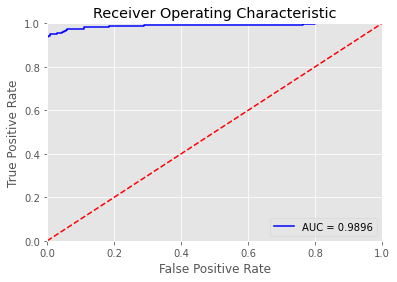

In [344]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROC for BernoulliNB, CountVectorizer.png', facecolor = 'white')
plt.show()

In [312]:
# Подбор порога
M = 0
for i in range(1001):
    threshold = 0.001 * i
    preds_1_test = np.where(preds1_test > threshold, 1, 0)
    acc = accuracy_score(y_test_win1, preds_1_test)
    if acc > M:
        M = acc
print(f'{M * 100}%')
thresholds = []
for i in range(1001):
    threshold = 0.001 * i
    preds_1_test = np.where(preds1_test > threshold, 1, 0)
    acc = accuracy_score(y_test_win1, preds_1_test)
    if acc == M:
        thresholds.append(threshold)

99.02120717781403%


In [313]:
max_res = 0
for threshold in thresholds:
    preds_1_train = np.where(clf_win1.predict_proba(X_train_win1)[:,1] > threshold, 1, 0)
    acc = accuracy_score(y_train_win1, preds_1_train)
    if acc > max_res:
        max_res = acc
        print(max_res, threshold)

0.999464237878382 0.561


In [316]:
conf_mat = metrics.confusion_matrix(y_test_win1, np.where(preds1_test > 0.561, 1, 0))
conf_mat = pd.DataFrame(conf_mat, index=clf_win1.classes_, columns=clf_win1.classes_)
dfi.export(conf_mat,"sms-spam, conf_mat, BernoulliNB, CountVectorizer, test, threshold_0.561.png")
conf_mat

,0,1
0,1574,1
1,17,247


In [317]:
conf_mat = metrics.confusion_matrix(y_train_win1, np.where(clf_win1.predict_proba(X_train_win1)[:,1] > 0.561, 1, 0))
conf_mat = pd.DataFrame(conf_mat, index=clf_win1.classes_, columns=clf_win1.classes_)
dfi.export(conf_mat,"sms-spam, conf_mat, BernoulliNB, CountVectorizer, train, threshold_0.561.png")
conf_mat

,0,1
0,3250,0
1,2,481


In [318]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test_win1, np.where(preds1_test > 0.561, 1, 0), output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
dfi.export(df_metrics,"sms-spam, BernoulliNB, CountVectorizer, test, threshold_0.561.png")
df_metrics

,precision,recall,f1-score,support
0,0.989315,0.999365,0.994315,1575.0
1,0.995968,0.935606,0.964844,264.0
accuracy,0.990212,0.990212,0.990212,1839.0
macro avg,0.992641,0.967486,0.979579,1839.0
weighted avg,0.990270,0.990212,0.990084,1839.0


In [319]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train_win1, np.where(clf_win1.predict_proba(X_train_win1)[:,1] > 0.561, 1, 0), output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
dfi.export(df_metrics,"sms-spam, BernoulliNB, CountVectorizer, train, threshold_0.561.png")
df_metrics

,precision,recall,f1-score,support
0,0.999385,1.000000,0.999692,3250.0
1,1.000000,0.995859,0.997925,483.0
accuracy,0.999464,0.999464,0.999464,3733.0
macro avg,0.999692,0.997930,0.998809,3733.0
weighted avg,0.999465,0.999464,0.999464,3733.0


# ROC for LogisticRegression, CountVectorizer

In [345]:
pred_prob2 = clf_win2.predict_proba(X_test_win2)

In [346]:
preds2_test = pred_prob2[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_win2, preds2_test)
roc_auc = metrics.auc(fpr, tpr)

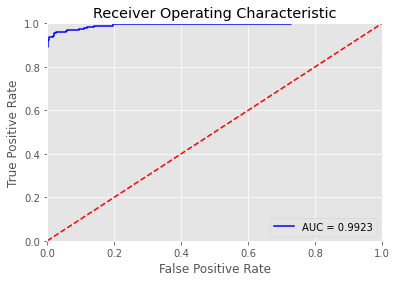

In [347]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROC for LogisticRegression, CountVectorizer.png', facecolor = 'white')
plt.show()

In [323]:
# Подбор порога
M = 0
for i in range(1001):
    threshold = 0.001 * i
    preds_2_test = np.where(preds2_test > threshold, 1, 0)
    acc = accuracy_score(y_test_win2, preds_2_test)
    if acc > M:
        M = acc
print(f'{M * 100}%')
thresholds = []
for i in range(1001):
    threshold = 0.001 * i
    preds_2_test = np.where(preds2_test > threshold, 1, 0)
    acc = accuracy_score(y_test_win2, preds_2_test)
    if acc == M:
        thresholds.append(threshold)

98.69494290375204%


In [335]:
max_res = 0
for threshold in thresholds:
    preds_2_train = np.where(clf_win2.predict_proba(X_train_win2)[:,1] > threshold, 1, 0)
    acc = accuracy_score(y_train_win2, preds_2_train)
    if acc > max_res:
        max_res = acc
        print(max_res, threshold)

1.0 0.11800000000000001


In [336]:
conf_mat = metrics.confusion_matrix(y_test_win2, np.where(preds2_test > 0.118, 1, 0))
conf_mat = pd.DataFrame(conf_mat, index=clf_win2.classes_, columns=clf_win2.classes_)
dfi.export(conf_mat,"sms-spam, conf_mat, LogisticRegression, CountVectorizer, test, threshold_0.118.png")
conf_mat

,0,1
0,1568,7
1,17,247


In [337]:
conf_mat = metrics.confusion_matrix(y_train_win2, np.where(clf_win2.predict_proba(X_train_win2)[:,1] > 0.118, 1, 0))
conf_mat = pd.DataFrame(conf_mat, index=clf_win2.classes_, columns=clf_win2.classes_)
dfi.export(conf_mat,"sms-spam, conf_mat, LogisticRegression, CountVectorizer, train, threshold_0.118.png")
conf_mat

,0,1
0,3250,0
1,0,483


In [338]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test_win2, np.where(preds2_test > 0.118, 1, 0), output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
dfi.export(df_metrics,"sms-spam, LogisticRegression, CountVectorizer, test, threshold_0.118.png")
df_metrics

,precision,recall,f1-score,support
0,0.989274,0.995556,0.992405,1575.0
1,0.972441,0.935606,0.953668,264.0
accuracy,0.986949,0.986949,0.986949,1839.0
macro avg,0.980858,0.965581,0.973037,1839.0
weighted avg,0.986858,0.986949,0.986844,1839.0


In [339]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train_win2, np.where(clf_win2.predict_proba(X_train_win2)[:,1] > 0.561, 1, 0), output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
dfi.export(df_metrics,"sms-spam, LogisticRegression, CountVectorizer, train, threshold_0.118.png")
df_metrics

,precision,recall,f1-score,support
0,1.0,1.0,1.0,3250.0
1,1.0,1.0,1.0,483.0
accuracy,1.0,1.0,1.0,3733.0
macro avg,1.0,1.0,1.0,3733.0
weighted avg,1.0,1.0,1.0,3733.0
